### lightGBM

### 電商銷量預估
目標:預測產品未來的銷量

流程:將資料整理合併order與deal，再以商品為單位，整理出產品相關特徵，並加上以種類為單位的銷售量週期(7天、14天、30天等)


###### order.csv
* columns:GUID(訂單編號) seller_GUID(廠商ID) subtotal(訂單金額) is_returned(是否退貨)create_time(訂購日期) business_hour_guid(商品檔次ID) order_from_type(來源裝置) user_id(訂購人ID) installment(刷卡分期)


###### deal.csv
* columns: business_hour_guid(商品檔次ID) seller_GUID(廠商ID),zip_code(供貨商郵遞區號),item_name(商品名稱),item_orig_price(原價),item_price(售價),item_default_daily_amount(上限),shopping_cart(是否為組合銷售),city_list(銷售頻道),deal_acc_business_group_id(事業群代號),deal_type_detail(商品子分類代號),code(google代號),is_travel_deal(是否為旅遊票券),installment_3months(信用卡可分3期),installment_6months(信用卡可分6期),installment_12months(信用卡可分12期),deny_installment(信用卡不可分期),shippingdate(配送天數),freight_amount(運費),discount_price(折扣後金額),is_wms(是否入倉)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import re
pd.options.display.max_columns = 100


In [2]:
order_ori =pd.read_csv("order.csv")
order_ori.rename(columns={'Unnamed: 4':'is_returned'}, inplace=True)
order_ori.head()

,GUID,seller_GUID,seller_name,subtotal,is_returned,create_time,business_hour_guid,order_from_type,user_id,installment
0,7358E8A1-A918-42CD-A846-AAEF0A0E2B67,35443723-B460-4CF5-AFD2-DF1F29ECB305,17P商品-HONEYWELL空氣循環機,2.0,1.0,2010-06-01 18:06:41.987,02C55598-E1E7-40E1-996B-371EAE55F840,1.0,1.111230e+09,0.0
1,A248B260-6366-4A2D-9A29-BF29A170A4AB,35443723-B460-4CF5-AFD2-DF1F29ECB305,17P商品-HONEYWELL空氣循環機,1350.0,0.0,2010-06-07 15:34:49.693,02C55598-E1E7-40E1-996B-371EAE55F840,1.0,1.111230e+09,0.0
2,8433DD4F-368D-41EA-9D3B-56E5BAE76BC2,35443723-B460-4CF5-AFD2-DF1F29ECB305,17P商品-HONEYWELL空氣循環機,1350.0,0.0,2010-06-07 22:28:37.443,02C55598-E1E7-40E1-996B-371EAE55F840,1.0,1.111194e+09,0.0
3,A85FC574-B5DA-43BE-88C8-326E1B90EE12,35443723-B460-4CF5-AFD2-DF1F29ECB305,17P商品-HONEYWELL空氣循環機,1350.0,0.0,2010-06-08 14:38:53.600,02C55598-E1E7-40E1-996B-371EAE55F840,1.0,1.111251e+09,0.0
4,EB9E799B-EB28-4F9F-820F-FF54BBF9E81F,35443723-B460-4CF5-AFD2-DF1F29ECB305,17P商品-HONEYWELL空氣循環機,1350.0,0.0,2010-06-09 08:45:17.770,02C55598-E1E7-40E1-996B-371EAE55F840,1.0,1.111387e+09,0.0


In [98]:
deal=pd.read_csv("deal(501mb;546Krows)_0605v1.csv")
deal

ParserError: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.


In [3]:
deal_ori=pd.read_csv("deal(492mb;546Krows)_0604v2.csv")
deal_ori

,business_hour_guid,seller_GUID,business_hour_order_time_s,business_hour_order_time_e,business_hour_deliver_time_s,business_hour_deliver_time_e,pic_alt,zip_code,city_name,district_name,item_name,item_orig_price,item_price,item_default_daily_amount,event_name,event_title,product_spec,shopping_cart,combo_pack_count,city_list,deal_acc_business_group_id,acc_business_group_name,deal_type_detail,code_name,code,is_travel_deal,installment_3months,installment_6months,installment_12months,deny_installment,shippingdate,is_long_contract,develope_sales_id,operation_sales_id,slug,ordered_quantity,ordered_total,category_list,freight_amount,discount_price,is_wms,ancestor_business_hour_guid
0,2E02DD3D-CAAE-4B35-92B7-4F78A91DA98D,03E99D0C-F9DD-4C00-882C-A86F15523634,2012-03-26 12:00:00 UTC,2012-04-03 12:00:00 UTC,2012-04-17 00:00:00 UTC,2012-05-01 00:00:00 UTC,印章,200,基隆市,仁愛區,廣容國際-韓風貴族原木印章組,1380,299,99,宅配：只要299元(含運)即可帶走【廣容國際】原價1380元韓風貴族原木印章：法國巴黎鐵塔/...,女孩間的熱門小物！18款韓風原木小印章|簡單為手帳和卡片添加精緻可愛小插畫。,NaN,0,1,[477|356],2,在地宅配,NaN,NaN,NaN,0,0,0,0,0,0.0,0,0,NaN,312.0,309,92391,[],0,NaN,0,NaN
1,35941352-7F60-4EC9-9ED1-C39F513613D5,03E99D0C-F9DD-4C00-882C-A86F15523634,2012-03-23 12:00:00 UTC,2012-03-30 12:00:00 UTC,2012-04-16 00:00:00 UTC,2012-04-30 00:00:00 UTC,皮夾,200,基隆市,仁愛區,廣容國際-韓風皇冠長夾,1280,299,99,宅配：只要299元(含運)即可擁有【廣容國際】原價1280元韓風皇冠長夾：可可咖/魅力紅/蜜...,時尚女孩超熱愛！韓風皮夾2種款式、8種顏色隨你挑|甜美可愛、優雅大方任你選！,NaN,0,1,[477|356],2,在地宅配,NaN,NaN,NaN,0,0,0,0,0,0.0,0,0,NaN,51.0,48,14352,[],0,NaN,0,NaN
2,1604EF28-C95F-43AF-BAF5-CE16EF8FF2F4,03E99D0C-F9DD-4C00-882C-A86F15523634,2012-01-29 12:00:00 UTC,2012-02-03 12:00:00 UTC,2012-02-06 00:00:00 UTC,2012-02-08 00:00:00 UTC,情人節限定,200,基隆市,仁愛區,廣容國際-情人節限量晶鑽對筆一組,1180,520,20,宅配商品：只要520元(含運)即可擁有【廣容國際】原價1180元情人節限量晶鑽對筆一組：三種...,限量！熱戀價520搶占情人的心|字字絮語化作晶鑽閃爍|對筆寫下彼此點點滴滴|再免費獲得LOV...,NaN,0,1,[477|356],2,在地宅配,NaN,NaN,NaN,0,0,0,0,0,0.0,0,0,NaN,92.0,92,47840,[],0,NaN,0,NaN
3,25243C05-6890-4CD5-987B-0D01BDAE905B,03E99D0C-F9DD-4C00-882C-A86F15523634,2012-02-27 12:00:00 UTC,2012-03-02 13:00:00 UTC,2012-03-19 00:00:00 UTC,2012-04-02 00:00:00 UTC,陶瓷杯,200,基隆市,仁愛區,廣容國際-雙層陶瓷杯(12選1),690,199,20,廣容國際,廣容國際,NaN,0,1,[465],2,在地宅配,NaN,NaN,NaN,0,0,0,0,0,0.0,0,0,NaN,201.0,196,39004,[],60,NaN,0,NaN
4,B172E6AB-D1D3-49F4-B901-C2CC6E37C7EB,03E99D0C-F9DD-4C00-882C-A86F15523634,2012-01-27 12:00:00 UTC,2012-02-03 12:00:00 UTC,2012-02-06 00:00:00 UTC,2012-03-06 00:00:00 UTC,手機包,200,基隆市,仁愛區,廣容國際-(第二彈)韓國三摺手機包,500,199,99,第二彈！宅配商品：只要199元(含運)即可購得【廣容國際】原價500元韓國三摺手機包x1+贈...,品味與實用兼具。韓國時尚手機包|幫親愛iPhone小物找個家|優於市面同款材質|嚴選軟皮革質...,NaN,0,1,[477|356],2,在地宅配,NaN,NaN,NaN,0,0,0,0,0,0.0,0,0,NaN,298.0,285,56715,[],0,NaN,0,NaN
5,C2ABA67E-FBDB-4146-9466-345AC17F424F,03E99D0C-F9DD-4C00-882C-A86F15523634,2012-03-21 12:00:00 UTC,2012-03-28 12:00:00 UTC,2012-04-12 00:00:00 UTC,2012-04-26 00:00:00 UTC,無痕掛勾,200,基隆市,仁愛區,廣容國際-無痕掛勾,300,177,99,宅配：只要177元(含運)即可帶走【廣容國際】原價300元無痕掛勾組：A系列(繽紛情境)5入組,雜亂空間的救星！防水、防油、不傷牆面|還可無限次重複黏貼使用|想掛哪|就掛哪！,NaN,0,1,[477|356],2,在地宅配,NaN,NaN,NaN,0,0,0,0,0,0.0,0,0,NaN,10.0,10,1770,[],0,NaN,0,NaN
6,CB688F82-AC95-4984-B346-BAC2BFF84C34,03E99D0C-F9DD-4C00-882C-A86F15523634,2011-11-11 12:00:00 UTC,2011-11-18 12:00:00 UTC,2011-11-23 00:00:00 UTC,2011-12-23 00:00:00 UTC,NaN,200,基隆市,仁愛區,廣容國際-韓國三摺手機包,500,199,99,宅配商品：只要199元(含運)即可購得【廣容國際】原價500元韓國三摺手機包x1+贈送一條腕...,品味與實用兼具。韓國時尚手機包|幫親愛iPhone小物找個家|優於市面同款材質|嚴選軟皮革質...,NaN,0,1,[356|477],2,在地宅配,NaN,NaN,NaN,0,0,0,0,0,0.0,0,0,NaN,694.0,659,131141,[],0,NaN,0,NaN
7,A6D5EFF5-C87F-493F-86A2-1A2FBEAEB841,03E99D0C-F9DD-4C00-882C-A86F15523634,2012-03-23 12:00:00 UTC,2012-03-30 12:00:00 UTC,2012-04-16 00:00:00 UTC,2012-04-30 00:00:00 UTC,皮夾,200,基隆市,仁愛區,廣容國際-韓風皇冠短夾/長夾,1080,299,99,宅配：只要299元(含運)即可擁有【廣容國際】原價1080/1280元韓風皇冠短/長夾。短夾...,時尚女孩超熱愛！韓風皮夾2種款式、8種顏色隨你挑|甜美可愛、優雅大方任你選！,NaN,0,1,[356|477],2,在地宅配,NaN,NaN,NaN,0,0,0,0,0,0.0,0,0,NaN,82.0,0,0,[],0,NaN,0,NaN
8,BEEBE648-5B61-4F63-B326-C82FB93B2B6C,03E99D0C-F9DD-4C00-882C-A86F15523634,2012-03-21 12:00:00 UTC,2012-03-28 12:00:00 UTC,2012-04-12 00:00:00 UTC,2012-04-26 00:00:00 UTC,無痕掛勾,200,基隆市,仁愛區,廣容國際-無痕掛勾,300,177,99,宅配：只要177元起(含運)即可帶走【廣容國際】原

In [5]:
dfOri=pd.merge(order_ori,deal_ori,how='left',on=['business_hour_guid','seller_GUID'])

In [6]:
dfOri.columns

Index(['GUID', 'seller_GUID', 'seller_name', 'subtotal', 'is_returned',
       'create_time', 'business_hour_guid', 'order_from_type', 'user_id',
       'installment', 'business_hour_order_time_s',
       'business_hour_order_time_e', 'business_hour_deliver_time_s',
       'business_hour_deliver_time_e', 'pic_alt', 'zip_code', 'city_name',
       'district_name', 'item_name', 'item_orig_price', 'item_price',
       'item_default_daily_amount', 'event_name', 'event_title',
       'product_spec', 'shopping_cart', 'combo_pack_count', 'city_list',
       'deal_acc_business_group_id', 'acc_business_group_name',
       'deal_type_detail', 'code_name', 'code', 'is_travel_deal',
       'installment_3months', 'installment_6months', 'installment_12months',
       'deny_installment', 'shippingdate', 'is_long_contract',
       'develope_sales_id', 'operation_sales_id', 'slug', 'ordered_quantity',
       'ordered_total', 'category_list', 'freight_amount', 'discount_price',
       'is_wms', 'ancesto

In [7]:
dfOri.head(10)

,GUID,seller_GUID,seller_name,subtotal,is_returned,create_time,business_hour_guid,order_from_type,user_id,installment,business_hour_order_time_s,business_hour_order_time_e,business_hour_deliver_time_s,business_hour_deliver_time_e,pic_alt,zip_code,city_name,district_name,item_name,item_orig_price,item_price,item_default_daily_amount,event_name,event_title,product_spec,shopping_cart,combo_pack_count,city_list,deal_acc_business_group_id,acc_business_group_name,deal_type_detail,code_name,code,is_travel_deal,installment_3months,installment_6months,installment_12months,deny_installment,shippingdate,is_long_contract,develope_sales_id,operation_sales_id,slug,ordered_quantity,ordered_total,category_list,freight_amount,discount_price,is_wms,ancestor_business_hour_guid
0,7358E8A1-A918-42CD-A846-AAEF0A0E2B67,35443723-B460-4CF5-AFD2-DF1F29ECB305,17P商品-HONEYWELL空氣循環機,2.0,1.0,2010-06-01 18:06:41.987,02C55598-E1E7-40E1-996B-371EAE55F840,1.0,1.111230e+09,0.0,2010-06-07 12:00:00 UTC,2010-06-16 12:00:00 UTC,2010-06-16 00:00:00 UTC,2010-12-31 00:00:00 UTC,NaN,100.0,台北市,中正區,只要1350元(含運費)！即可購得原價2690元進口HONEYWELL空氣循環扇HT-380...,2690.0,1350.0,2.0,只要1350元(含運費)！即可購得原價2690元進口HONEYWELL空氣循環扇HT-380...,NaN,NaN,0.0,1.0,[199],7.0,宅配,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,14.0,14.0,18900.0,[],0.0,NaN,0.0,NaN
1,A248B260-6366-4A2D-9A29-BF29A170A4AB,35443723-B460-4CF5-AFD2-DF1F29ECB305,17P商品-HONEYWELL空氣循環機,1350.0,0.0,2010-06-07 15:34:49.693,02C55598-E1E7-40E1-996B-371EAE55F840,1.0,1.111230e+09,0.0,2010-06-07 12:00:00 UTC,2010-06-16 12:00:00 UTC,2010-06-16 00:00:00 UTC,2010-12-31 00:00:00 UTC,NaN,100.0,台北市,中正區,只要1350元(含運費)！即可購得原價2690元進口HONEYWELL空氣循環扇HT-380...,2690.0,1350.0,2.0,只要1350元(含運費)！即可購得原價2690元進口HONEYWELL空氣循環扇HT-380...,NaN,NaN,0.0,1.0,[199],7.0,宅配,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,14.0,14.0,18900.0,[],0.0,NaN,0.0,NaN
2,8433DD4F-368D-41EA-9D3B-56E5BAE76BC2,35443723-B460-4CF5-AFD2-DF1F29ECB305,17P商品-HONEYWELL空氣循環機,1350.0,0.0,2010-06-07 22:28:37.443,02C55598-E1E7-40E1-996B-371EAE55F840,1.0,1.111194e+09,0.0,2010-06-07 12:00:00 UTC,2010-06-16 12:00:00 UTC,2010-06-16 00:00:00 UTC,2010-12-31 00:00:00 UTC,NaN,100.0,台北市,中正區,只要1350元(含運費)！即可購得原價2690元進口HONEYWELL空氣循環扇HT-380...,2690.0,1350.0,2.0,只要1350元(含運費)！即可購得原價2690元進口HONEYWELL空氣循環扇HT-380...,NaN,NaN,0.0,1.0,[199],7.0,宅配,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,14.0,14.0,18900.0,[],0.0,NaN,0.0,NaN
3,A85FC574-B5DA-43BE-88C8-326E1B90EE12,35443723-B460-4CF5-AFD2-DF1F29ECB305,17P商品-HONEYWELL空氣循環機,1350.0,0.0,2010-06-08 14:38:53.600,02C55598-E1E7-40E1-996B-371EAE55F840,1.0,1.111251e+09,0.0,2010-06-07 12:00:00 UTC,2010-06-16 12:00:00 UTC,2010-06-16 00:00:00 UTC,2010-12-31 00:00:00 UTC,NaN,100.0,台北市,中正區,只要1350元(含運費)！即可購得原價2690元進口HONEYWELL空氣循環扇HT-380...,2690.0,1350.0,2.0,只要1350元(含運費)！即可購得原價2690元進口HONEYWELL空氣循環扇HT-380...,NaN,NaN,0.0,1.0,[199],7.0,宅配,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,14.0,14.0,18900.0,[],0.0,NaN,0.0,NaN
4,EB9E799B-EB28-4F9F-820F-FF54BBF9E81F,35443723-B460-4CF5-AFD2-DF1F29ECB305,17P商品-HONEYWELL空氣循環機,1350.0,0.0,2010-06-09 08:45:17.770,02C55598-E1E7-40E1-996B-371EAE55F840,1.0,1.111387e+09,0.0,2010-06-07 12:00:00 UTC,2010-06-16 12:00:00 UTC,2010-06-16 00:00:00 UTC,2010-12-31 00:00:00 UTC,NaN,100.0,台北市,中正區,只要1350元(含運費)！即可購得原價2690元進口HONEYWELL空氣循環扇HT-380...,2690.0,1350.0,2.0,只要1350元(含運費)！即可購得原價2690元進口HONEYWELL空氣循環扇HT-380...,NaN,NaN,0.0,1.0,[199],7.0,宅配,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,14.0,14.0,18900.0,[],0.0,NaN,0.0,NaN
5,2362DCF0-6A02-4EE1-A1FB-5845007F280B,35443723-B460-4CF5-AFD2-DF1F29ECB305,17P商品-HONEYWELL空氣循環機,1350.0,0.0,2010-06-09 10:43:47.083,02C55598-E1E7-40E1-996B-371EAE55F840,1.0,1.111361e+09,0.0,2010-06-07 12:00:00 UTC,2010-06-16 12:00:00 UTC,2010-06-16 00:00:00 UTC,2010-12-31 00:00:00 UTC,NaN,100.0,台北市,中正區,只要1350元(含運費)！即可購得原價2690元進口HONEYWELL空氣循環扇HT-380...,2690.0,1350.0,2.0,只要1350元(含運費)！即可購得原價2690元進口HONEYWELL空氣循環扇HT-380...,NaN,NaN,0.0,1.0,[199],7.0,宅配,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,14.0,14.0,18900.0,[],0.0,NaN,0.0,NaN
6,D3635D7C-8FAD-4C

In [10]:
tempdf=dfOri[(dfOri.code.isnull()==False)]

### 重複值

In [11]:
dfOri.shape

(4080857, 50)

In [ ]:
(dfOri.apply(lambda x:x.unique().shape[0],axis=0)/dfOri.shape[0]).plot(kind='bar')

### 遺漏值

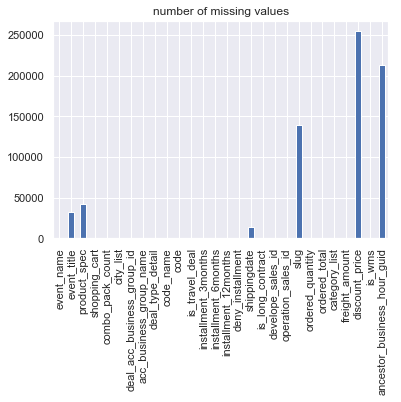

In [12]:
tempdfg=tempdf
tempdfg.isnull().sum().plot(kind='bar',title='number of missing values')

In [ ]:
dfOri.category.value_counts(dropna=False)

___

# 使用tempdf (code 暫無null值資料)進行運算


#### 商品特徵欄位
--檔期接續問題
--計算時間問題
##### 目前已可取得：
* 商品ID V
* 品牌：將不同品牌使用Label Encoding 加以標示
* 顧客性別：結合訂單member表格，利用客戶欄位，計算該商品有多少男性或女性購買(人數or 百分比)
* 顧客年齡：結合訂單member表格，利用客戶欄位，計算該商品的消費者年齡的平均、中位數(注意outlier!!)
* 關鍵字：先挑出根據出現詞頻最高的5~10個行銷用詞(如：熱銷、買_送_...等)，再計算每個商品標題中含有行銷用詞之次數(或將其分等級)
* 品類：從order檔案與deal檔案結合	
* 促銷與否：結合discount檔案，看其商品是否有加入促銷活動(1 or 0) 豪仔
* 分期：計算該商品是否有提供分期付款優惠(3,6,12) V
* 配送時間：V
* 上架月份：利用business_hour_order_time_s找出檔次上架之月份(若為累積檔次取其出現頻率最多者)V
* 上架星期：利用business_hour_order_time_s找出該天為星期幾(若為累積檔次取其出現頻率最多者) V
* 上架時間：利用business_hour_order_time_s找出上架時間點(以24小時為欄位) V
* 檔期長度(天數)：利用business_hour_order_time_s、business_hour_order_time_e欄位相減	(可先做) V
* 開賣前三天的銷量:利用order訂單與business_hour_order_time_s時間相減進行計算 V
* 是否預購：計算訂購與配送之時間差(若超過三週則設為預購，以1,0劃分) (可先做)V
* 與同類商品的單位價格中位數比較：計算該產品的產品單位價格中位數，與其單位價格比較(使用百分比)
* 熱銷：觀察該商品上過熱銷排行榜的次數(用整個平台的每日銷量，判斷是否有為全平台的Top20)再除以檔期長度 取百分比
* 可超取：可否超商取貨
* 單位價格（單一檔期)	
* 總銷售量 (單一檔期)
* 商品平均價格(全檔期)
* 總銷售量(全檔期)
* 該品類最高銷售量商品(單一檔期)待定
* 該品類最高銷售量商品(全檔期)待定


#### 目標變數：
* 該商品於未來7.14.30.60.180天的預估銷量：利用order訂單與business_hour_order_time_s時間相減進行計算，除以總銷量取得百分比(可先做)


### 將欄位轉換格式為datetime

In [90]:
import datetime

tempdf1=tempdf[['create_time','business_hour_order_time_s','business_hour_order_time_e','business_hour_deliver_time_s','business_hour_deliver_time_e']].reset_index(drop=True)


In [91]:
for i in ['business_hour_order_time_s','create_time','business_hour_order_time_e','business_hour_deliver_time_s','business_hour_deliver_time_e']:
    tempdf1[i]=pd.to_datetime(tempdf1[i])

In [92]:
tempdf1['product_launch_month']=tempdf1['business_hour_order_time_s'].apply(lambda x:x.month)
tempdf1['product_launch_hour']=tempdf1['business_hour_order_time_s'].apply(lambda x:x.hour)
tempdf1['product_launch_weekday']=tempdf1['business_hour_order_time_s'].apply(lambda x:x.weekday())
tempdf1['campagin_period']=(tempdf1['business_hour_order_time_e']-tempdf1['business_hour_order_time_s']).apply(lambda x:x.days)
tempdf1['order_deliver_days']=(tempdf1['business_hour_deliver_time_s']-tempdf1['business_hour_order_time_s']).apply(lambda x : x.days )

In [95]:
def trans(x):
    if x>=3:
        return 1
    elif x<3:
        return 0
    else:
        return np.NaN

tempdf1["presales"]=tempdf1['order_deliver_days'].apply(trans)


In [96]:
tempdf1

,create_time,business_hour_order_time_s,business_hour_order_time_e,business_hour_deliver_time_s,business_hour_deliver_time_e,product_launch_month,product_launch_hour,product_launch_weekday,campagin_period,order_deliver_days,presales
0,2012-12-20 14:59:46.003,2012-12-20 12:00:00+00:00,2013-01-03 15:25:00+00:00,2013-01-03 00:00:00+00:00,2013-01-14 00:00:59+00:00,12,12,3,14,13,1
1,2012-12-20 15:29:54.327,2012-12-20 12:00:00+00:00,2013-01-03 15:25:00+00:00,2013-01-03 00:00:00+00:00,2013-01-14 00:00:59+00:00,12,12,3,14,13,1
2,2012-12-20 16:55:05.927,2012-12-20 12:00:00+00:00,2013-01-03 15:25:00+00:00,2013-01-03 00:00:00+00:00,2013-01-14 00:00:59+00:00,12,12,3,14,13,1
3,2012-12-20 21:04:36.750,2012-12-20 12:00:00+00:00,2013-01-03 15:25:00+00:00,2013-01-03 00:00:00+00:00,2013-01-14 00:00:59+00:00,12,12,3,14,13,1
4,2012-12-20 23:58:01.423,2012-12-20 12:00:00+00:00,2013-01-03 15:25:00+00:00,2013-01-03 00:00:00+00:00,2013-01-14 00:00:59+00:00,12,12,3,14,13,1
5,2012-12-21 00:22:23.593,2012-12-20 12:00:00+00:00,2013-01-03 15:25:00+00:00,2013-01-03 00:00:00+00:00,2013-01-14 00:00:59+00:00,12,12,3,14,13,1
6,2012-12-21 09:01:17.703,2012-12-20 12:00:00+00:00,2013-01-03 15:25:00+00:00,2013-01-03 00:00:00+00:00,2013-01-14 00:00:59+00:00,12,12,3,14,13,1
7,2012-12-21 10:15:21.610,2012-12-20 12:00:00+00:00,2013-01-03 15:25:00+00:00,2013-01-03 00:00:00+00:00,2013-01-14 00:00:59+00:00,12,12,3,14,13,1
8,2012-12-21 11:03:13.407,2012-12-20 12:00:00+00:00,2013-01-03 15:25:00+00:00,2013-01-03 00:00:00+00:00,2013-01-14 00:00:59+00:00,12,12,3,14,13,1
9,2012-12-21 11:09:37.017,2012-12-20 12:00:00+00:00,2013-01-03 15:25:00+00:00,2013-01-03 00:00:00+00:00,2013-01-14 00:00:59+00:00,12,12,3,14,13,1
